In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as sp
from PIL import Image
import math
import scipy.stats

#Q_MATRIX defines the default matrix to quantise using for DCT quantisation
Q_MATRIX = np.array([[8,8,6,6,4,4,2,2],
                       [8,8,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [2,2,2,2,2,2,2,2],
                       [2,2,2,2,2,2,2,2]],np.int32)

In [4]:
#snr function returns snr as var/rss for given original image f and new image g
def snr(f,g):
    f = np.asanyarray(f, dtype="float")
    g = np.asanyarray(g, dtype="float")
    var = np.sum(np.square(f))
    rss = np.sum(np.square(f-g))
    return np.where(var == 0, float("inf"), 10*np.log10(var/rss))

In [5]:
#psnr function returns peak snr as maxval^2/mse for given new image a and original image oa
def psnr(a,oa):
    a = np.asanyarray(a, dtype="float")
    mse = np.square(oa-a).mean()
    return np.where(mse == 0, 0, 10*np.log10(255*255/mse))

In [6]:
def mse(og,new):
    return np.square(og-new).mean()

**PART ONE**
==========
DCT Compression

In [7]:
#dct_wave function is taken from lab work and simply performs one-dimensional DCT along an array
def dct_wave(N, w):
    wave = np.zeros(N, dtype='float')
    
    if (w==0):
        norm_factor = np.sqrt(1/N)
    else:
        norm_factor = np.sqrt(2/N)
    for i in range(N):   
        wave[i] = norm_factor * np.cos( w * (np.pi * (2*i + 1))/(2*N) )
        
    return wave

In [8]:
#function also taken from lab work, using dct_wave to find 2d dct
def dct_wave_2d(N, u, v):
    
    wave_x = dct_wave(N, u)
    wave_y = dct_wave(N, v)
    
    return np.outer(wave_x, wave_y)

This cell below simply prints an example output set of basis images for DCT compression usage on an 8x8 image block, to show that the function(s) work as they should.

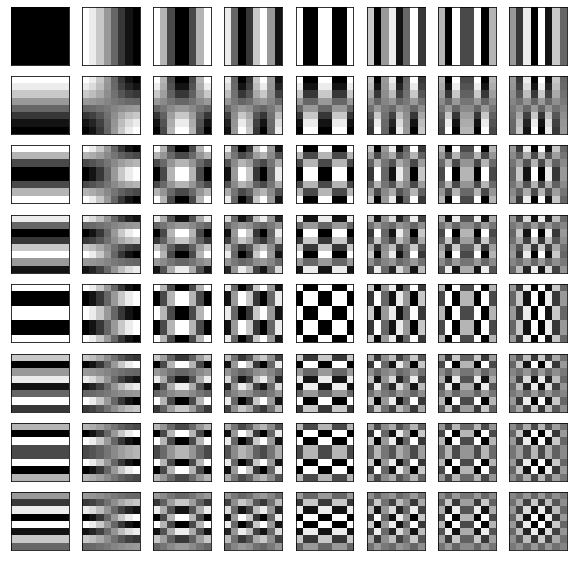

In [9]:
n = 8

fig = plt.figure(figsize=(10,10))
i = 0
for u in range(n):
    for v in range(n):
        
        plt.subplot(n,n,i+1)
        plt.imshow(dct_wave_2d(n, u, v), norm=None, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        i += 1

The following cell similarly loads in the *lena.png* test image and prints it to test valid load

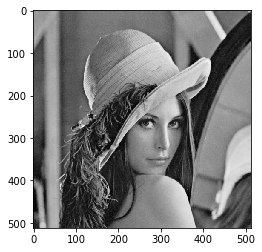

(512, 512)


In [11]:
#data_dir = r"C:\Users\callu\Pictures\Test\\"
data_dir = r"./coursework-data/"
img = Image.open(data_dir+"lena.png").convert("L")
img = np.asarray(img)
plt.imshow(img, cmap="gray")
plt.show()
print(img.shape)

In [20]:
#performs inverse DCT on given block
def DCT_inv(coeffs, dct_basis, N):
    recon = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            recon+=coeffs[k,l]*dct_basis[k,l]
    return recon

In [21]:
#gets basis vectors for given DCT block size
def makeBasis(inp):
    inp=inp
    
    dct_basis = np.zeros((inp, inp, inp, inp)) 

    for k in range(inp):
        for l in range(inp):
            dct_basis[k, l] = dct_wave_2d(inp,k,l)
    
    return dct_basis

In [22]:
#calculates DCT block for given image block
def dctBlock(im, dct_basis, N):
    coeffs = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            coefficient = np.dot(im.flatten(), dct_basis[k,l].flatten()) # dot product x.b
            coeffs[k,l] = coefficient
    return coeffs

In [23]:
#performs full DCT conversion of given image, using given blocksize, threshold and quantisation flag
def bdctTransform(image, bs, t=0, q=False):
    base = makeBasis(bs)
    dctim = np.zeros((image.shape))
    for i in range(0,image.shape[0],bs):
        for j in range(0,image.shape[1],bs):
            im = image[i:i+bs,j:j+bs]
            dctres = dctBlock(im,base,bs)
            if t<=0:
                None
            else:
                dctres = blockThresh(dctres, t)
            if q == True:
                dctres = qBlock(dctres)
            dctim[i:i+bs,j:j+bs] = dctres
    return dctim

In [24]:
#performs full inverse DCT conversion of DCTimage using given blocksize
def bidctTransform(dctim, bs):
    base = makeBasis(bs)
    recim = np.zeros((dctim.shape))
    for i in range(0,dctim.shape[0],bs):
        for j in range(0,dctim.shape[1],bs):
            im = dctim[i:i+bs,j:j+bs]
            recres = DCT_inv(im,base,bs)
            recim[i:i+bs,j:j+bs] = recres
    return recim

The cells below is simply testing that the whole process (converting and inversing) works for various block sizes.
Also compares their MSE, to show that there is very little difference between them (without any thresholding or quantisation)

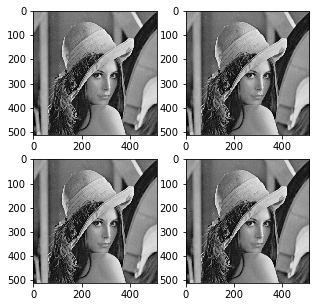

In [25]:
test4 = bidctTransform(bdctTransform(img, 4), 4)
test8 = bidctTransform(bdctTransform(img, 8), 8)
test16 = bidctTransform(bdctTransform(img, 16), 16)
test32 = bidctTransform(bdctTransform(img, 32), 32)
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
plt.imshow(test4,cmap="gray")
plt.subplot(2,2,2)
plt.imshow(test8,cmap="gray")
plt.subplot(2,2,3)
plt.imshow(test16,cmap="gray")
plt.subplot(2,2,4)
plt.imshow(test32,cmap="gray")
plt.show()

In [26]:
print("MSE4: ", mse(img,test4))
print("MSE8: ", mse(img,test8))
print("MSE16: ", mse(img,test16))
print("MSE32: ", mse(img,test32))

MSE4:  1.3538113173258678e-27
MSE8:  8.195562519706917e-26
MSE16:  8.72347352897334e-26
MSE32:  3.2621194139080036e-25


In [27]:
#thresholds a DCT block using a given threshold percentage value
def blockThresh(block, thresh):
    bign = 0
    bigs = 0
    for r in block:
        for c in r:
            if abs(c)>bigs:
                if abs(c)>bign:
                    bigs=bign
                    bign=abs(c)
                    continue
                bigs=abs(c)
    for x in range(block.shape[0]):
        for y in range(block.shape[0]):
            if abs(block[x,y])<thresh*bign:
                block[x,y] = 0
    return block

In [28]:
#gets images and DCTimages for a given image at specific threshold levels
#these are used later as a good test bed (and can be used the same for any number of other test images)
#this saves repeated calculation of the thresholded DCT images, improving code readability
def getThreshes(img):
    threshes = [0.01,0.02,0.03,0.05,0.1,0.15,0.2,0.3,0.4,0.5]
    threshd = []
    pthreshd = []
    for i in range(0,10):
        thresh = threshes[i]
        pthreshd.append(bdctTransform(img,8,thresh))
        threshd.append(bidctTransform(pthreshd[i],8))
    return threshd, pthreshd

The cell below contains three functions that work in tandem to find compression ratios of thresholded DCT images.

In [31]:
def findCompPix(block):
    bs = block.shape[0]
    for x in range(bs-1,-1,-1):
        for y in range(bs-1,-1,-1):
            if block[x,y] != 0:
                if (x+y)<=bs-1:
                    return np.square(bs)-triNum(x+y+1)
                return triNum((bs+1)-(x+y)-1)
    return bs*bs

def triNum(n):
    num = int(n*(n+1)/2)
    return num

def findCompRatio(im, bs):
    dim = im.shape[0]
    totalpix = 0
    comppix = 0
    for i in range(0,dim,bs):
        for j in range(0,dim,bs):
            block = im[i:i+bs,j:j+bs]
            totalpix += np.square(bs)
            comppix += np.square(bs)-findCompPix(block)
    return totalpix/comppix, comppix

The next two cells serve to simply print the snr, peaksnr and compression ratio, as well as the number of bits required to represent the resultant image, for each level of thresholding determined earlier

In [34]:
#regular signal-to-noise
threshd,pthreshd = getThreshes(img)
snrs = []
sratios = []
print("control snr:",snr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1])
for i in range(len(pthreshd)):
    print(i,"= ",snr(img,threshd[i])," compression ratio:",findCompRatio(pthreshd[i], 8)[0], " bits after compression:", findCompRatio(pthreshd[i], 8)[1])
    sratios.append(findCompRatio(pthreshd[i], 8)[0])
    snrs.append(snr(threshd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


control snr: inf  compression ratio: 1.3061224489795917  bits after compression: 200704
0 =  33.416754653707024  compression ratio: 2.6332104507146945  bits after compression: 99553
1 =  30.04748896864395  compression ratio: 4.66440098930624  bits after compression: 56201
2 =  28.18248149308072  compression ratio: 7.556106419162367  bits after compression: 34693
3 =  25.92017078659858  compression ratio: 12.747094578166788  bits after compression: 20565
4 =  22.966098971850712  compression ratio: 25.145707434052756  bits after compression: 10425
5 =  21.202831479130563  compression ratio: 37.5510671823521  bits after compression: 6981
6 =  20.243509930219968  compression ratio: 47.05510680308742  bits after compression: 5571
7 =  19.01221156871197  compression ratio: 57.791887125220455  bits after compression: 4536
8 =  18.504355013923227  compression ratio: 61.899409681227866  bits after compression: 4235
9 =  18.14340844878969  compression ratio: 63.565470417070806  bits after compre

In [35]:
#peak-signal-to-noise
psnrs = []
pratios = []
print("control psnr:",psnr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1]*8)
for i in range(len(pthreshd)):
    print(i,"= ",psnr(threshd[i],img)," compression ratio:",findCompRatio(pthreshd[i], 8)[0], " bits after compression:", findCompRatio(pthreshd[i], 8)[1]*8)
    pratios.append(findCompRatio(pthreshd[i], 8)[0])
    psnrs.append(psnr(threshd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


control psnr: 0.0  compression ratio: 1.3061224489795917  bits after compression: 1605632
0 =  39.10388620400878  compression ratio: 2.6332104507146945  bits after compression: 796424
1 =  35.734620518945704  compression ratio: 4.66440098930624  bits after compression: 449608
2 =  33.86961304338247  compression ratio: 7.556106419162367  bits after compression: 277544
3 =  31.607302336900336  compression ratio: 12.747094578166788  bits after compression: 164520
4 =  28.653230522152473  compression ratio: 25.145707434052756  bits after compression: 83400
5 =  26.889963029432316  compression ratio: 37.5510671823521  bits after compression: 55848
6 =  25.93064148052172  compression ratio: 47.05510680308742  bits after compression: 44568
7 =  24.69934311901373  compression ratio: 57.791887125220455  bits after compression: 36288
8 =  24.191486564224988  compression ratio: 61.899409681227866  bits after compression: 33880
9 =  23.830539999091446  compression ratio: 63.565470417070806  bits a

The cell below simply prints the same information on a line graph

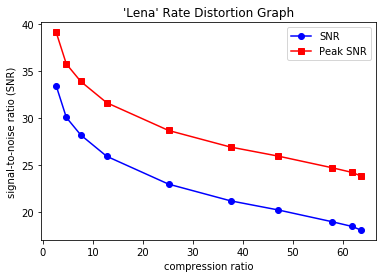

In [39]:
plt.plot(sratios, snrs, 'bo-', label="SNR")
plt.plot(pratios, psnrs, 'rs-',label="Peak SNR")
plt.title("'Lena' Rate Distortion Graph")
plt.xlabel('compression ratio')
plt.ylabel('signal-to-noise ratio (SNR)')
plt.legend()
plt.show()

In [41]:
#quantises DCT block using given target matrix
def qBlock(block, target=Q_MATRIX):
    quant = np.zeros(target.shape)
    #print(target)
    for x in range(block.shape[0]):
        for y in range(block.shape[1]):
            quant[x,y] = round(block[x,y]/target[x,y])*target[x,y]
    return quant

In [42]:
#gets quantised images and DCT images at specific threshold levels
def getQuants(img):
    threshes = [0.01,0.02,0.03,0.05,0.1,0.15,0.2,0.3,0.4,0.5]
    quantd = []
    pquantd = []
    for i in range(0,10):
        thresh = threshes[i]
        pquantd.append(bdctTransform(img,8,thresh,True))
        quantd.append(bidctTransform(pquantd[i],8))
    return quantd,pquantd

The next two cells serve to simply print the snr, peaksnr and compression ratio, as well as the number of bits required to represent the resultant image, for each level of thresholding determined earlier

In [43]:
quantd,pquantd = getQuants(img)
snrs = []
sratios = []
print("control snr:",snr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1]*8)
for i in range(len(pquantd)):
    print(i,"= ",snr(img,quantd[i])," compression ratio:",findCompRatio(pquantd[i], 8)[0], " bits after compression:", findCompRatio(pquantd[i], 8)[1]*8)
    sratios.append(findCompRatio(pquantd[i], 8)[0])
    snrs.append(snr(quantd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


control snr: inf  compression ratio: 1.3061224489795917  bits after compression: 1605632
0 =  33.18675298321881  compression ratio: 2.6332104507146945  bits after compression: 796424
1 =  29.97343503399696  compression ratio: 4.66440098930624  bits after compression: 449608
2 =  28.1445408295405  compression ratio: 7.556106419162367  bits after compression: 277544
3 =  25.903232161806006  compression ratio: 12.747094578166788  bits after compression: 164520
4 =  22.96004337995944  compression ratio: 25.145707434052756  bits after compression: 83400
5 =  21.199457022935576  compression ratio: 37.5510671823521  bits after compression: 55848
6 =  20.241013869059046  compression ratio: 47.05510680308742  bits after compression: 44568
7 =  19.010487191117278  compression ratio: 57.791887125220455  bits after compression: 36288
8 =  18.50286083380157  compression ratio: 61.899409681227866  bits after compression: 33880
9 =  18.14205228945929  compression ratio: 63.565470417070806  bits after

In [44]:
psnrs = []
pratios = []
print("control psnr:",psnr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1])
for i in range(len(pquantd)):
    print(i,"= ",psnr(quantd[i],img)," compression ratio:",findCompRatio(pquantd[i], 8)[0], " bits after compression:", findCompRatio(pquantd[i], 8)[1])
    pratios.append(findCompRatio(pquantd[i], 8)[0])
    psnrs.append(psnr(quantd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


control psnr: 0.0  compression ratio: 1.3061224489795917  bits after compression: 200704
0 =  38.873884533520574  compression ratio: 2.6332104507146945  bits after compression: 99553
1 =  35.66056658429872  compression ratio: 4.66440098930624  bits after compression: 56201
2 =  33.83167237984226  compression ratio: 7.556106419162367  bits after compression: 34693
3 =  31.590363712107767  compression ratio: 12.747094578166788  bits after compression: 20565
4 =  28.647174930261198  compression ratio: 25.145707434052756  bits after compression: 10425
5 =  26.886588573237333  compression ratio: 37.5510671823521  bits after compression: 6981
6 =  25.928145419360806  compression ratio: 47.05510680308742  bits after compression: 5571
7 =  24.69761874141904  compression ratio: 57.791887125220455  bits after compression: 4536
8 =  24.18999238410333  compression ratio: 61.899409681227866  bits after compression: 4235
9 =  23.829183839761047  compression ratio: 63.565470417070806  bits after comp

In [45]:
#a properly defined function for generating the data required to graph all of the SNR and Peak SNR information needed
#in order to print proper rate-distortion graphs
def getGraph(blockimg,pblockimg, ogimg, verbose):
    snrs = []
    sratios = []
    if verbose:
        print("control snr:",snr(ogimg,ogimg)," compression ratio:",findCompRatio(ogimg, 8)[0], " bits after compression:", findCompRatio(ogimg, 8)[1]*8)
    for i in range(len(pblockimg)):
        if verbose:
            print(i,"= ",snr(ogimg,blockimg[i])," compression ratio:",findCompRatio(pblockimg[i], 8)[0], " bits after compression:", findCompRatio(pblockimg[i], 8)[1]*8)
        sratios.append(findCompRatio(pblockimg[i], 8)[0])
        snrs.append(snr(blockimg[i],ogimg))
    psnrs = []
    pratios = []
    if verbose:
        print("control psnr:",psnr(ogimg,ogimg)," compression ratio:",findCompRatio(ogimg, 8)[0], " bits after compression:", findCompRatio(ogimg, 8)[1])
    for i in range(len(pblockimg)):
        if verbose:
            print(i,"= ",psnr(blockimg[i],ogimg)," compression ratio:",findCompRatio(pblockimg[i], 8)[0], " bits after compression:", findCompRatio(pblockimg[i], 8)[1])
        pratios.append(findCompRatio(pblockimg[i], 8)[0])
        psnrs.append(psnr(blockimg[i],ogimg))
    return sratios, snrs, pratios, psnrs

Now the preceding functions are tested fully on three test images - ***lena.png***, ***zelda.png*** and ***barbara.png***

In [46]:
#data_dir = r"C:\Users\callu\Pictures\Test\\"
data_dir = r"./coursework-data/"
lena = Image.open(data_dir+"lena.png").convert("L")
lena = np.asarray(lena)
zeld = Image.open(data_dir+"zelda.png").convert("L")
zeld = np.asarray(zeld)
barb = Image.open(data_dir+"barbara.png").convert("L")
barb = np.asarray(barb)
imgs = [lena,zeld,barb]

In [47]:
lthreshd, lpthreshd = getThreshes(lena)
zthreshd, zpthreshd = getThreshes(zeld)
bthreshd,bpthreshd = getThreshes(barb)
lquantd, lpquantd = getQuants(lena)
zquantd, zpquantd = getQuants(zeld)
bquantd,bpquantd = getQuants(barb)

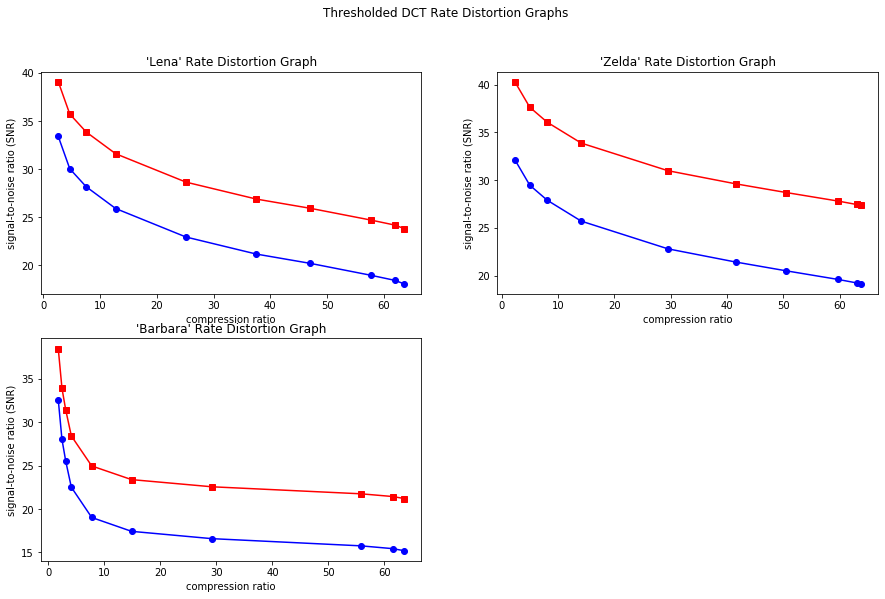

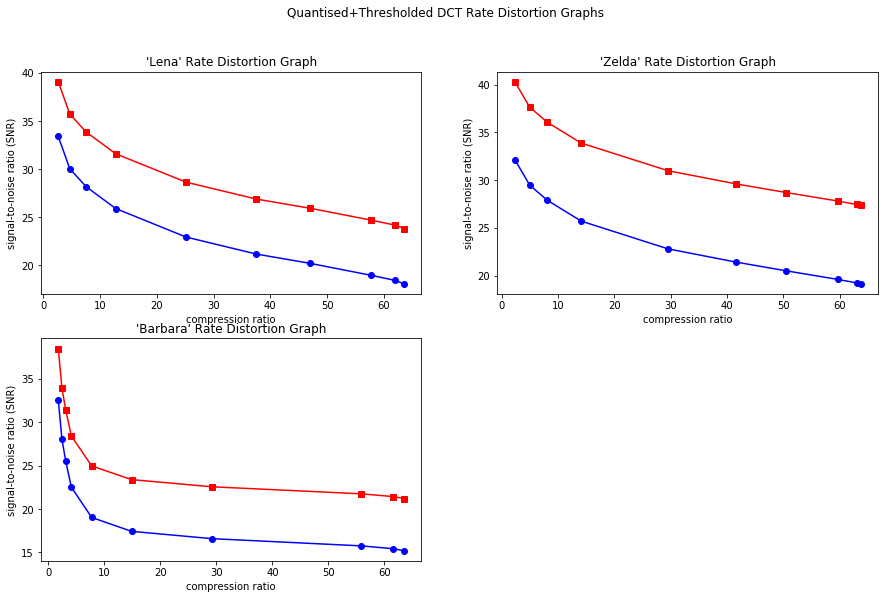

In [48]:
tl = getGraph(lthreshd, lpthreshd, lena, False)
ql = getGraph(lquantd,lpquantd, lena, False)
tz = getGraph(zthreshd, zpthreshd, zeld, False)
qz = getGraph(zquantd, zpquantd, zeld, False)
tb = getGraph(bthreshd, bpquantd, barb, False)
qb = getGraph(bquantd, bpquantd, barb, False)
ts = [tl,tz,tb]
qs = [ql,qz,qb]
titles = ["'Lena' Rate Distortion Graph","'Zelda' Rate Distortion Graph","'Barbara' Rate Distortion Graph"]
fig = plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(2,2,(i+1))
    plt.plot(ts[i][0], ts[i][1], 'bo-',ts[i][2], ts[i][3], 'rs-')
    plt.title(titles[i])
    plt.xlabel('compression ratio')
    plt.ylabel('signal-to-noise ratio (SNR)')
fig.suptitle('Thresholded DCT Rate Distortion Graphs')
plt.show()
fig = plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(2,2,(i+1))
    plt.plot(ts[i][0], ts[i][1], 'bo-',ts[i][2], ts[i][3], 'rs-')
    plt.title(titles[i])
    plt.xlabel('compression ratio')
    plt.ylabel('signal-to-noise ratio (SNR)')
fig.suptitle('Quantised+Thresholded DCT Rate Distortion Graphs')
plt.show()

**PART TWO**
===========
Laplacian Pyramid Compression

In [49]:
#creates a gaussian kernel of appropriate size, based on given sigma (standard deviation)
#by default, it's normalised, since that's what we want it to be
#taken from lab work/labsheets
def gaussian_kernel(sigma, norm=True):
    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # is the size even?
        size = size + 1 # make it odd 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel

In [50]:
#2d convolution function for convolving a given kernel over a given image
#developed in labs with help from the sheet
def conv2d(im, kernel):

    h = kernel.shape[0]//2 # half the kernel size
    impad = np.pad(im,h,"edge")
    output = np.zeros(im.shape, dtype='float')
    for i in range(h,impad.shape[0]-h):
        for j in range(h,impad.shape[1]-h):

            output[i-h, j-h] = np.dot(impad[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())
    return output

In [51]:
#reduce and expand functoins both perform their expected operations
#both were taken from work done and used in labs
def reduce(im, kernel):
    
    # blur the input 
    im_blurred = conv2d(im.astype('float'), kernel)
    return im_blurred[::2,::2] # return subsampled version

def expand(im, kernel):

    # upsample by a factor of two by pixel duplication
    upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)
    for i in range(upsampled.shape[0]):
        for j in range(upsampled.shape[1]):
            upsampled[i, j] = im[i//2,j//2]

    # blur the upsampled image
    blurred = conv2d(upsampled.astype('float'), kernel)

    return blurred

The following cell just quickly tests the convolution function (and by extension the reduce/expand operations)

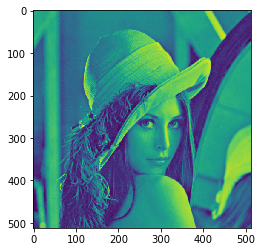

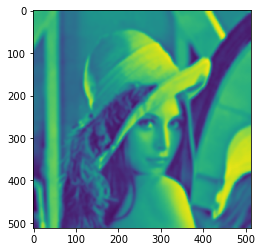

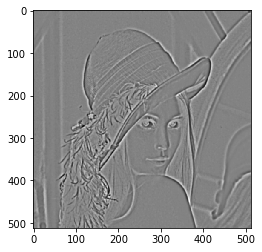

In [52]:
plt.imshow(img)
plt.show()

big = gaussian_kernel(3)
smol = gaussian_kernel(1)

blurred = conv2d(img,big)
padded_kernel = np.pad(smol, (big.shape[0]-smol.shape[0])//2, 'constant')
dog = big - padded_kernel

plt.imshow(blurred)
plt.show()

dogged = conv2d(img,dog)
plt.imshow(dogged, cmap="gray")
plt.show()

In [54]:
#builds both the gaussian and laplacian pyramids for a given image and gaussian kernel
def build_pyramids(img, g):
    gauss_pyramid = [] # list to store the generated levels

    gauss_pyramid.append(img.astype('float')) # level 0 is the image

    n = int(np.log2(img.shape[0]))+1 # assume that the image size is a power of 2
    for i in range(1,n):

        
        level = reduce(gauss_pyramid[i-1], g)

        gauss_pyramid.append(level)

    lap_pyramid=[]
    for j in range(0,n-1):
        diff = gauss_pyramid[j]-expand(gauss_pyramid[j+1],g)
        #diff *= (255.0/diff.max())
        lap_pyramid.append(diff)

    return gauss_pyramid,lap_pyramid

#shows all images in a given pyramid
def show_pyramid(pyramid):

        fig = plt.figure(figsize=(18,7))

        for i in range(len(pyramid)):

            plt.subplot(2,5,i+1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title('level '+str(i))
            plt.xticks([])
            plt.yticks([])

        plt.show()

The next cell is a simple validation of the produced pyramids

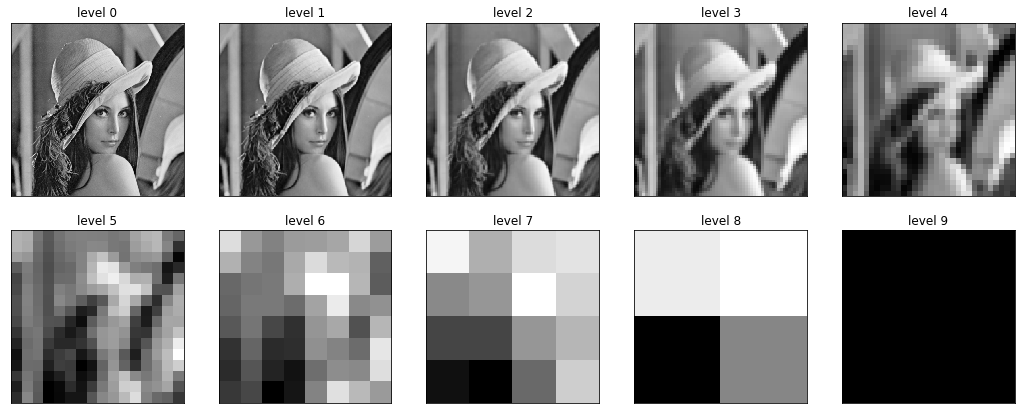

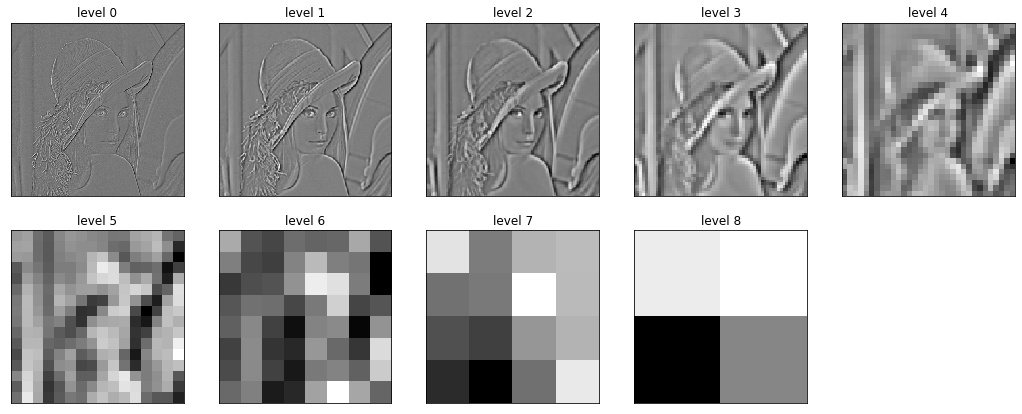

In [55]:
gauss,lapl = build_pyramids(img, smol)

show_pyramid(gauss)

show_pyramid(lapl)

In [56]:
#thresholds each image in a pyramid to only the values greater in value than 10% of the maximum value in each image
#while threshold could be passed as a parameter, aalmost all laplacian images follow the same histogram distribution
#most values are relatively very small, so a 10% threshold is about right, most of the time
def threshPyramid(pyramid):
    result = []
    for xj in range(len(pyramid)):
        temp_store = []
        pmax = 0
        for pix in pyramid[xj].ravel():
            if abs(pix)>pmax:
                pmax=abs(pix)
        for pix in pyramid[xj].ravel():
            if abs(pix)>(0.1*pmax):
                temp_store.append(pix)
            else:
                temp_store.append(0)
        new_store = np.asarray(temp_store)
        result.append(new_store.reshape((int(512//math.pow(2,(xj)))), int(512//math.pow(2,(xj)))))
    return result

This cell just tests/gets thresholding of the existing laplacian pyramid

In [57]:
thresh_lap = threshPyramid(lapl)
quant_lap = threshPyramid(lapl)

In [58]:
#quantises all images in a pyramid according to the level
#quantisation is done on a bit basis (gradually changing the number of bits allocated to representing each pixel)
#This results in impressive compression factors 
def quantisePyramid(pyramid):
    depth = len(pyramid)
    for i in range(0,depth):
        diff = pyramid[i].max() - pyramid[i].min()
        numdiff = float(diff)/(np.power(2,(i+1)))
        vals = []
        for n in range(np.power(2,(i+1))):
            vals.append(pyramid[i].min()+((n+1)*numdiff))
        for x in range(pyramid[i].shape[0]):
            for y in range(pyramid[i].shape[1]):
                closest = math.inf
                best = 0
                for v in vals:
                    if abs(pyramid[i][x,y]-v)<closest:
                        closest = abs(pyramid[i][x,y]-v)
                        best = v
                pyramid[i][x,y] = best
    return pyramid

This cell just tests/gets quantisation of the existing thresholded laplacian pyramid and shows difference

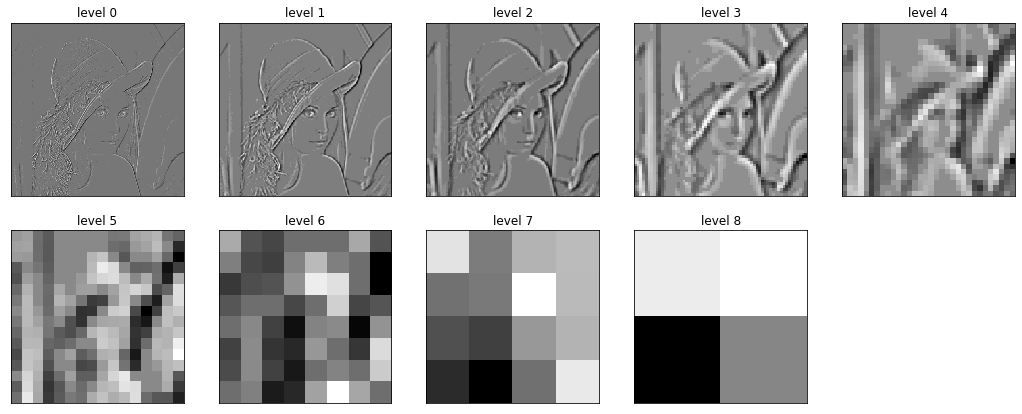

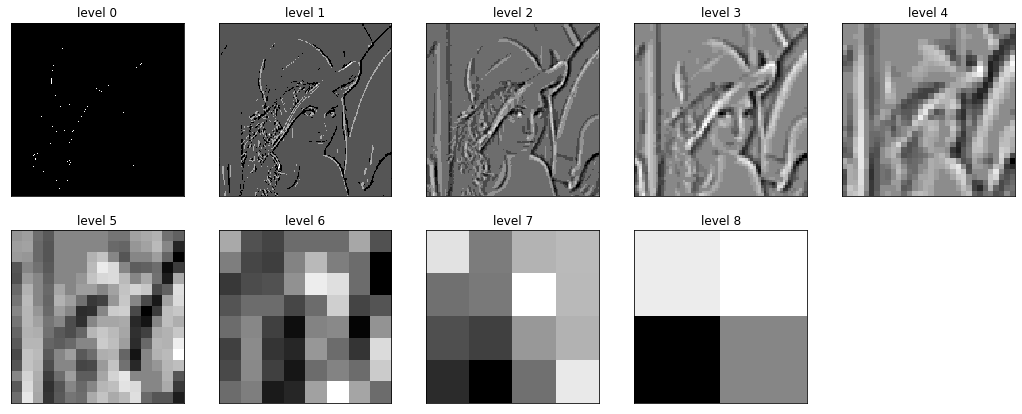

In [59]:
quantisePyramid(quant_lap)
show_pyramid(thresh_lap)
show_pyramid(quant_lap)

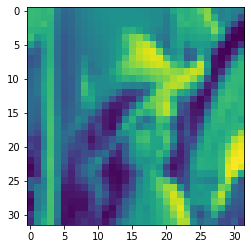

A (32, 32)
B (32, 32)


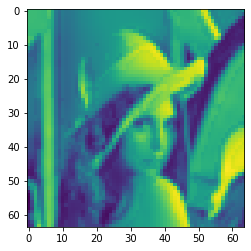

A (64, 64)
B (64, 64)


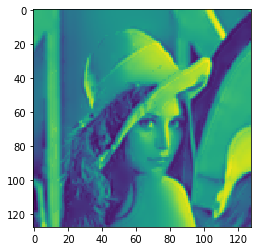

A (128, 128)
B (128, 128)


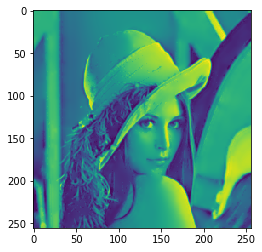

A (256, 256)
B (256, 256)


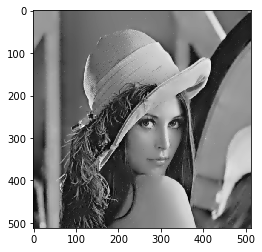

A (512, 512)
B (512, 512)


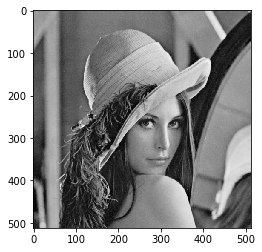

In [107]:
new_im = thresh_lap[4] + expand(gauss[5],smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[4].shape)
new_im = thresh_lap[3] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[3].shape)
new_im = thresh_lap[2] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[2].shape)
new_im = thresh_lap[1] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[1].shape)
new_im = thresh_lap[0] + expand(new_im,smol)
new_im *= (255.0/new_im.max())
plt.imshow(new_im, cmap="gray")
plt.show()
print("A",new_im.shape)
print("B",gauss[0].shape)
plt.imshow(img, cmap="gray")
plt.show()

In [60]:
#takes a starting level, gaussian image, laplacian pyramid and gaussian filter
#uses repeated expansions to recreate/reconstruct the original imge from highly compressed laplacian pyramid
#and a much smaller subsampled version of the original image
def antiPyramid(level, g, laps, filt=smol):
    new_im = g
    for i in range(level-1,-1,-1):
        new_im = laps[i] + expand(new_im,filt)
    return new_im

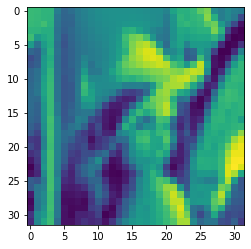

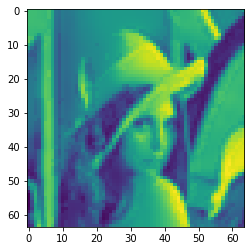

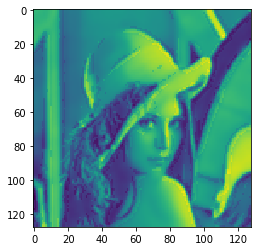

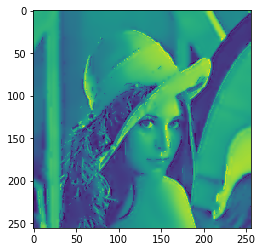

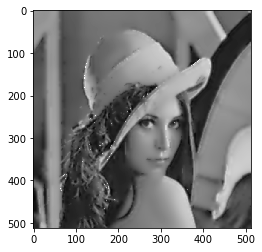

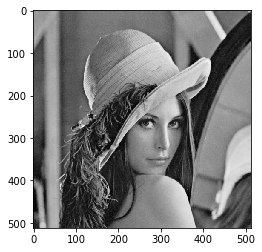

In [109]:
new_im = quant_lap[4] + expand(gauss[5],smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[3] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[2] + expand(gauss[3],smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[1] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[0] + expand(new_im,smol)
plt.imshow(new_im, cmap="gray")
plt.show()
plt.imshow(img, cmap="gray")
plt.show()

In [61]:
#returns rough estimate of the compression factor of using a specific gaussian starting level of a given image
def lapCompRatio(level, imshape=512):
    gaussbits = np.square(imshape/np.power(2,level))*8
    lapbits = 0
    for i in range(level):
        laptemp = np.square(imshape/np.power(2,level))*(i+1)
        lapbits += laptemp
    return (imshape*imshape*8)/(gaussbits+lapbits), (gaussbits+lapbits)

The following cells test the preceding functions on the three test images used earlier - ***lena.png***, ***zelda.png*** and ***barbara.png***

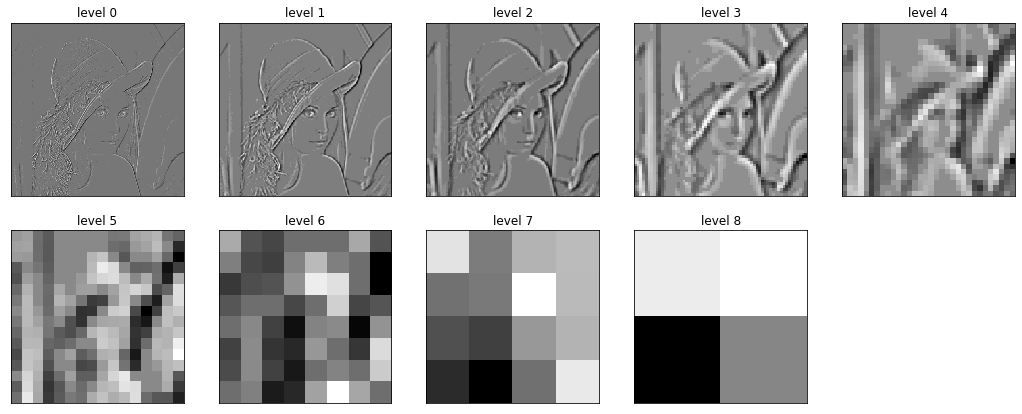

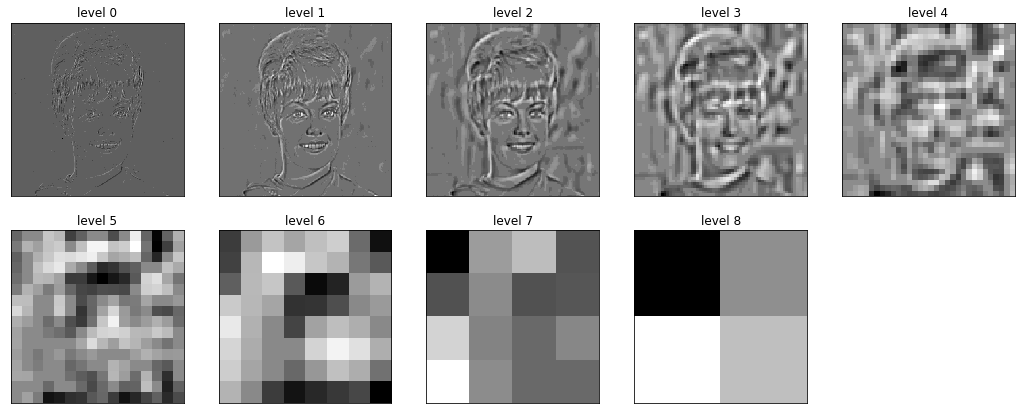

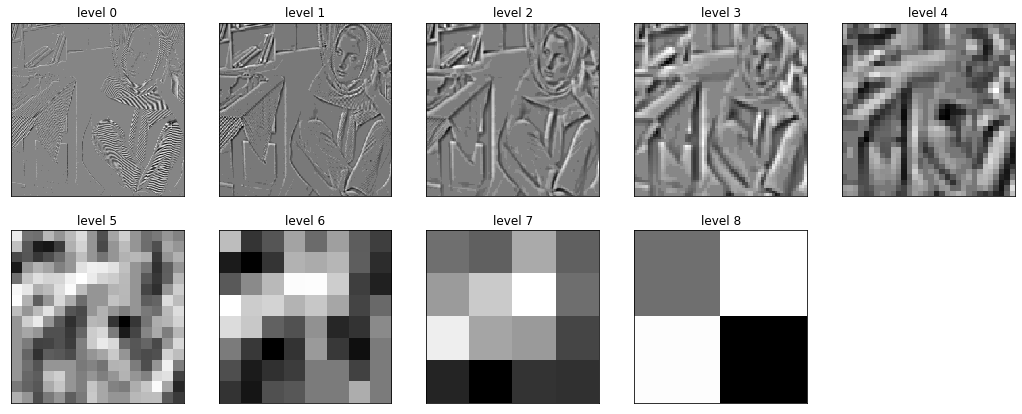

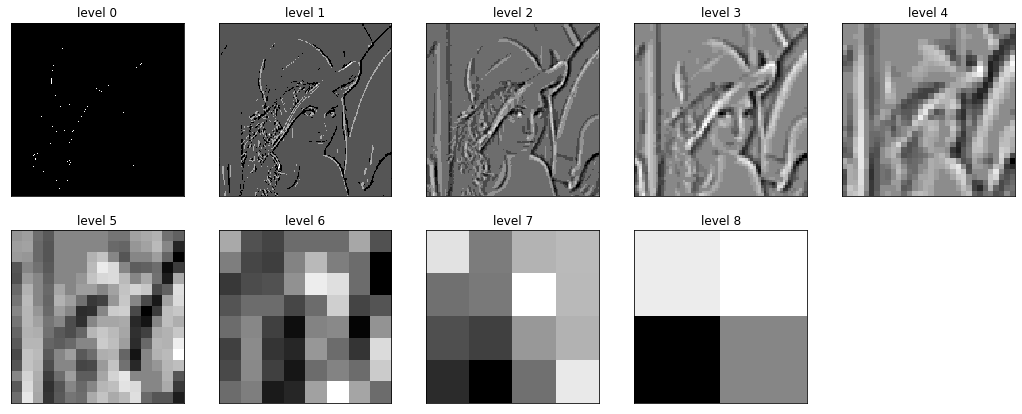

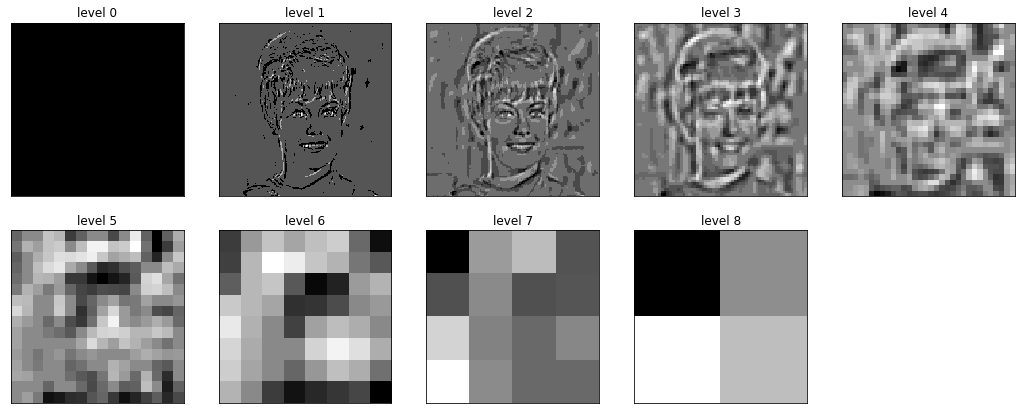

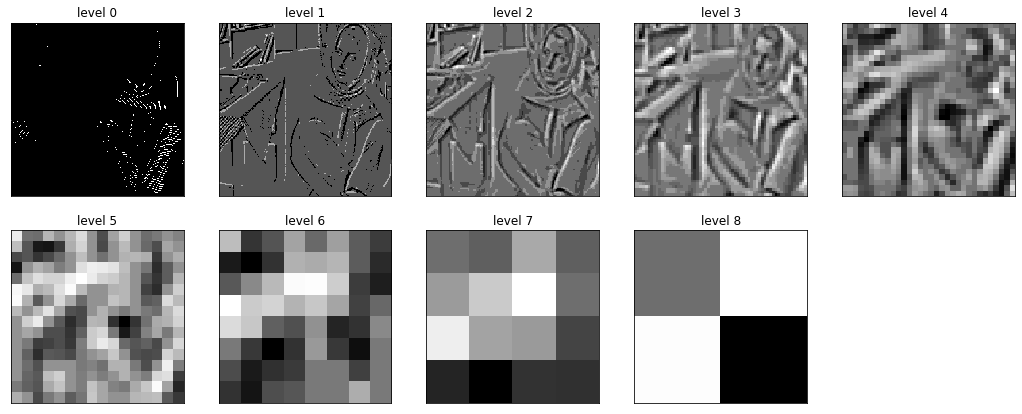

In [62]:
gausses = [None,None,None]
laps = [None,None,None]
tlaps = []
qlaps = []
for i in range(3):
    gausses[i], laps[i] = build_pyramids(imgs[i],smol)
for l in laps:
    tlaps.append(threshPyramid(l))
    qlaps.append(threshPyramid(l))
for q in qlaps:
    q = quantisePyramid(q)

for t in tlaps:
    show_pyramid(t)
for q in qlaps:
    show_pyramid(q)

In [65]:
ltims = []
ztims = []
btims = []
lqims = []
zqims = []
bqims = []

for i in range(0,7):
    ltims.append(antiPyramid(i,gausses[0][i],tlaps[0]))
    ztims.append(antiPyramid(i,gausses[1][i],tlaps[1]))
    btims.append(antiPyramid(i,gausses[2][i],tlaps[2]))
    lqims.append(antiPyramid(i,gausses[0][i],qlaps[0]))
    zqims.append(antiPyramid(i,gausses[1][i],qlaps[1]))
    bqims.append(antiPyramid(i,gausses[2][i],qlaps[2]))

In [66]:
#slightly different function for properly getting the SNRs, peak SNRs and other values associated with drawing 
#rate-distortion graphs for the laplacian pyramid compression functions
def getLapGraph(newimg, ogimg, verbose):
    snrs = []
    sratios = []
    if verbose:
        print("control snr:",snr(ogimg,ogimg)," compression ratio:",lapCompRatio(0)[0], " bits after compression:", lapCompRatio(0)[1])
    for i in range(len(newimg)):
        if verbose:
            print(i,"= ",snr(ogimg,newimg[i])," compression ratio:",lapCompRatio(i)[0], " bits after compression:", lapCompRatio(i)[1])
        sratios.append(lapCompRatio(i)[0])
        snrs.append(snr(newimg[i],ogimg))
    psnrs = []
    pratios = []
    if verbose:
        print("control psnr:",psnr(ogimg,ogimg)," compression ratio:",lapCompRatio(0)[0], " bits after compression:", lapCompRatio(0)[1])
    for i in range(len(newimg)):
        if verbose:
            print(i,"= ",psnr(newimg[i],ogimg)," compression ratio:",lapCompRatio(i)[0], " bits after compression:", lapCompRatio(i)[1])
        pratios.append(lapCompRatio(i)[0])
        psnrs.append(psnr(newimg[i],ogimg))
    return sratios, snrs, pratios, psnrs

In [69]:
ql = getLapGraph(lqims, lena, False)
qz = getLapGraph(zqims, zeld, False)
qb = getLapGraph(bqims, barb, False)

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


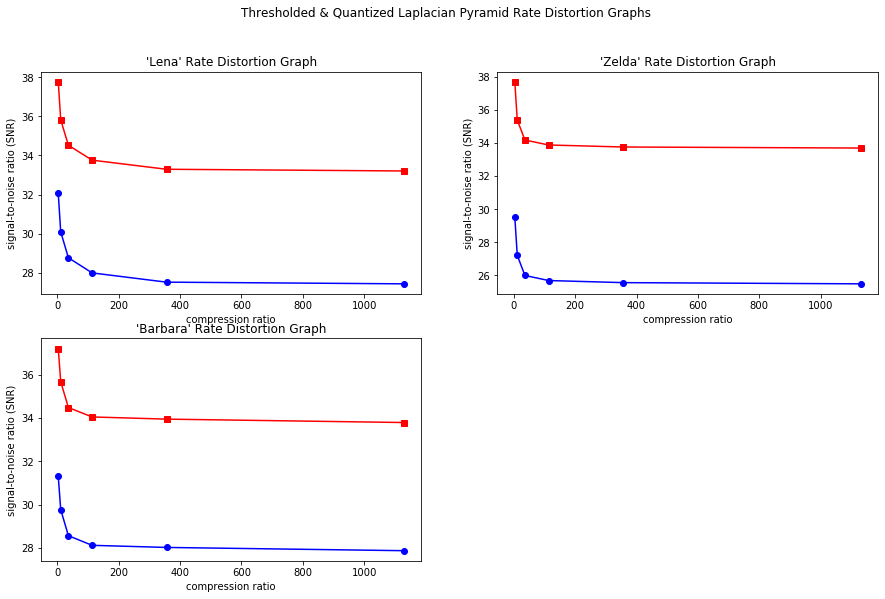

In [70]:
qs = [ql,qz,qb]
titles = ["'Lena' Rate Distortion Graph","'Zelda' Rate Distortion Graph","'Barbara' Rate Distortion Graph"]
fig = plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(2,2,(i+1))
    plt.plot(ts[i][0][1:], ts[i][1][1:], 'bo-',ts[i][2][1:], ts[i][3][1:], 'rs-')
    plt.title(titles[i])
    plt.xlabel('compression ratio')
    plt.ylabel('signal-to-noise ratio (SNR)')
fig.suptitle('Thresholded & Quantized Laplacian Pyramid Rate Distortion Graphs')
plt.show()